<a href="https://colab.research.google.com/github/ifnamartin/Loan-Default/blob/main/Loan_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h1 align="center"><font size="5">Classification with Python</font></h1>



We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [ ]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-08-27 03:05:15--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.02s   

2022-08-27 03:05:16 (1.05 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [ ]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
df.shape

(346, 10)

### Convert to date time object


In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


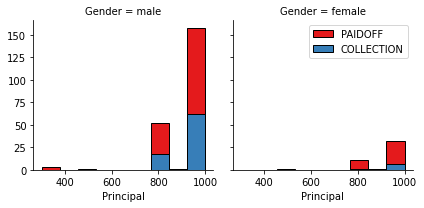

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

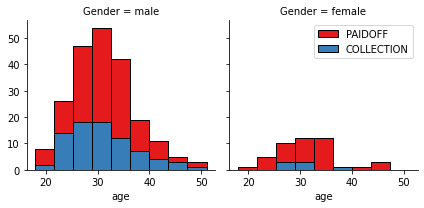

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


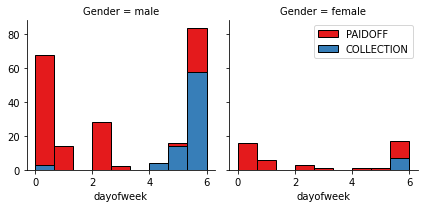

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [ ]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [ ]:
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y = df['loan_status'].values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now we will use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression



# Train - Test Split

For most of the models we will build, we will need to tune the parameters to find the best model. In order to do so, we will split the data from the training file **loan_train.csv** into train set and test set.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)



To find the best **k** we will train the model with values of k varying from 1 to 20, calculate the obtained accuracies and store them in an array


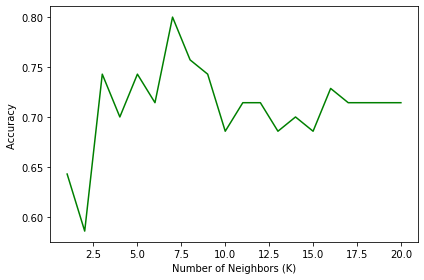

The best accuracy was of 0.8 with k= 7


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

ks = 21
accuracies = np.zeros((ks-1))
for k in range(1,ks):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    accuracies[k-1] = metrics.accuracy_score(y_test, yhat)
accuracies

plt.plot(range(1,ks),accuracies,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was of", accuracies.max(), "with k=", accuracies.argmax()+1)

So now that we have found that the best value is **k=7**, we can build the model with all the training data from the file **loan_train.csv**

In [ ]:
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X,y)
neigh

KNeighborsClassifier(n_neighbors=7)

# Decision Tree


We will try to build our decision tree maximizing the accuracy. In order to do so, we will vary the value of the parameter **maximum depth** and find the one that gives the best results.

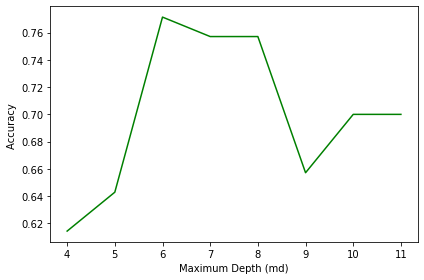

The best accuracy was of 0.7714285714285715 with a maximum depth of 6


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn import metrics
import matplotlib.pyplot as plt

mds = 12
accuracies = np.zeros((mds-4))
for md in range(4,mds):
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = md)
    loanTree.fit(X_train,y_train)
    predTree = loanTree.predict(X_test)
    accuracies[md-4] = metrics.accuracy_score(y_test, predTree)
plt.plot(range(4,mds),accuracies,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Maximum Depth (md)')
plt.tight_layout()
plt.show()
print( "The best accuracy was of", accuracies.max(), "with a maximum depth of", accuracies.argmax()+4)

Now that we have the optimal **maximum depth** of the tree, we can build the model with all the training data from the file **loan_train.csv**

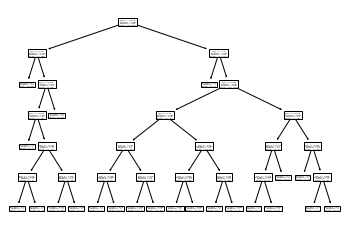

In [ ]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree.fit(X,y)

tree.plot_tree(loanTree)
plt.show()

# Support Vector Machine


Because the SVM algorithm offers different kernel functions, we will first try to decide which one to choose by maximizing accuracy using the already divided train and test sets from **loan_train.csv**. We need to choose between:
```
1.Linear ('linear')
2.Polynomial ('poly')
3.Radial basis function ('rbf')
4.Sigmoid ('sigmoid')
```

[0.69142857 0.70647931 0.74789916 0.66233766]


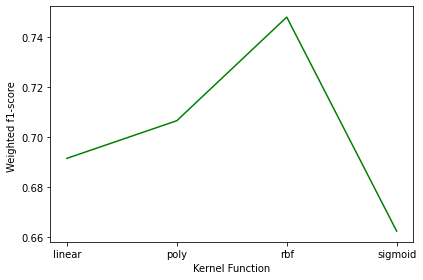

The best weighted f1 score was 0.7478991596638657 using the rbf function as the kernel function


In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix,f1_score

wf1scores = np.zeros((4))
kfs = ['linear','poly','rbf','sigmoid']

for kf in range(4):
    clf = svm.SVC(C=0.8,kernel = kfs[kf])
    clf.fit(X_train,y_train)
    yhat = clf.predict(X_test)
    wf1scores[kf] = f1_score(y_test, yhat, average='weighted')
print(wf1scores)
plt.plot(kfs,wf1scores,'g')
plt.ylabel('Weighted f1-score ')
plt.xlabel('Kernel Function')
plt.tight_layout()
plt.show()
print( "The best weighted f1 score was", wf1scores.max(), "using the", kfs[wf1scores.argmax()], "function as the kernel function")

We will be plotting the confusion matrix and the classification report

              precision    recall  f1-score   support

           0       0.50      0.20      0.29        15
           1       0.81      0.95      0.87        55

    accuracy                           0.79        70
   macro avg       0.66      0.57      0.58        70
weighted avg       0.75      0.79      0.75        70

Confusion matrix, without normalization
[[ 3 12]
 [ 3 52]]


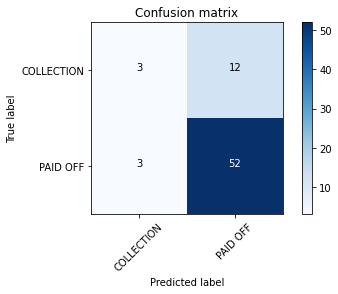

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

clf = svm.SVC(C=0.8,kernel = 'rbf')
clf.fit(X_train,y_train)
yhat = clf.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAID OFF'],normalize= False,  title='Confusion matrix')

Now that we have picked the **Radial basis function** as the kernel function, we can build the model with all the training data from **loan_train.csv**

In [ ]:
clf = svm.SVC(C=0.8,kernel = 'rbf')
clf.fit(X,y)

SVC(C=0.8)

# Logistic Regression


The logistic regression function in python offers the user the option to choose the solver used in the optimization problems. The options are **{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}**. We will try to find the one that gives the best results for our particular model.

[0.49 0.49 0.58 0.49 0.49]


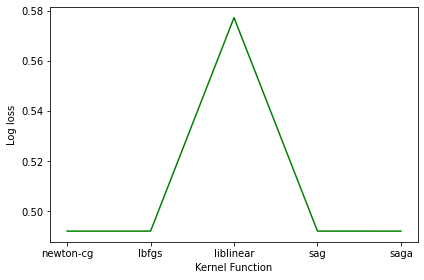

The best log loss was 0.5772287609479654 using the liblinear algorithm as the solver


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,f1_score, log_loss

loglosses = np.zeros((5))
svs = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for sv in range(5):
    LR = LogisticRegression(C=0.01, solver=svs[sv]).fit(X_train,y_train)
    yhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)
    loglosses[sv] = log_loss(y_test, yhat_prob)
print(loglosses)
plt.plot(svs,loglosses,'g')
plt.ylabel('Log loss')
plt.xlabel('Kernel Function')
plt.tight_layout()
plt.show()
print( "The best log loss was", loglosses.max(), "using the", svs[loglosses.argmax()], "algorithm as the solver")

              precision    recall  f1-score   support

           0       0.18      0.13      0.15        15
           1       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


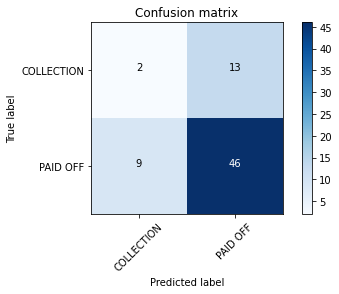

In [ ]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAID OFF'],normalize= False,  title='Confusion matrix')

Now that we have picked the **liblinear** as the optimization algorithm, we can build the model with all the training data from **loan_train.csv**

In [ ]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)

# Model Evaluation using Test set


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

method = np.asarray(['KNN','Decision Tree','SVM','LogisticRegression'])
jac = np.zeros((4))
f1 = np.zeros((4))
log = ['NA','NA','NA',0]

First, download and load the test set:


In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-08-27 03:05:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-08-27 03:05:30 (421 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Preprocess the new dataset to match the previous one

In [ ]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [ ]:
test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y = test_df['loan_status'].values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## K-Nearest Neighbors evaluation

              precision    recall  f1-score   support

           0       0.44      0.29      0.35        14
           1       0.78      0.88      0.82        40

    accuracy                           0.72        54
   macro avg       0.61      0.58      0.59        54
weighted avg       0.69      0.72      0.70        54

Confusion matrix, without normalization
[[ 4 10]
 [ 5 35]]


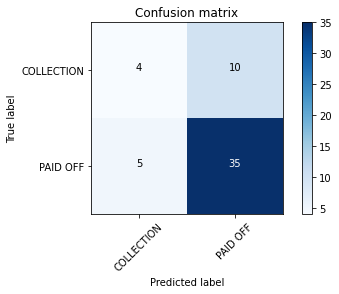

In [ ]:
yhat_knn = neigh.predict(X)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat_knn, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y, yhat_knn))
jac[0] = jaccard_score(y,yhat_knn)
f1[0] = f1_score(y,yhat_knn,average='weighted')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAID OFF'],normalize= False,  title='Confusion matrix')

## Decision Tree Evaluation

              precision    recall  f1-score   support

           0       0.50      0.21      0.30        14
           1       0.77      0.93      0.84        40

    accuracy                           0.74        54
   macro avg       0.64      0.57      0.57        54
weighted avg       0.70      0.74      0.70        54

Confusion matrix, without normalization
[[ 3 11]
 [ 3 37]]


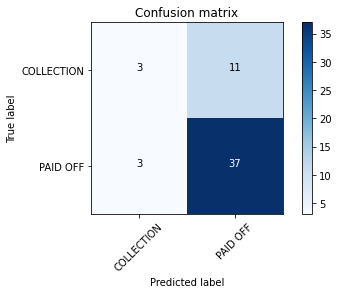

In [ ]:
yhat_dtr = loanTree.predict(X)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat_dtr, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y, yhat_dtr))
jac[1] = jaccard_score(y,yhat_dtr)
f1[1] = f1_score(y,yhat_dtr,average='weighted')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAID OFF'],normalize= False,  title='Confusion matrix')

## Support Vector Machines Evaluation

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.74      0.97      0.84        40

    accuracy                           0.72        54
   macro avg       0.37      0.49      0.42        54
weighted avg       0.55      0.72      0.62        54

Confusion matrix, without normalization
[[ 0 14]
 [ 1 39]]


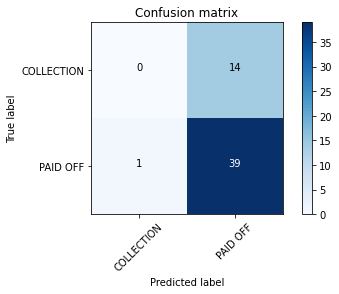

In [ ]:
yhat_svm = clf.predict(X)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat_svm, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y, yhat_svm))
jac[2] = jaccard_score(y,yhat_svm)
f1[2] = f1_score(y,yhat_svm,average='weighted')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAID OFF'],normalize= False,  title='Confusion matrix')

## Logistic Regression Evaluation

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.74      1.00      0.85        40

    accuracy                           0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

[0.7  0.7  0.62 0.63] [0.7  0.73 0.72 0.74] ['NA', 'NA', 'NA', 0.5566084946309205]
Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


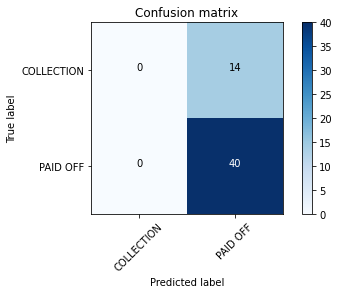

In [ ]:
yhat_lr = LR.predict(X)
yhat_lrprob = LR.predict_proba(X)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat_lr, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y, yhat_lr,zero_division = 0))
jac[3] = jaccard_score(y,yhat_lr)
f1[3] = f1_score(y,yhat_lr,average='weighted')
log[3] = log_loss(y,yhat_lrprob)
print(f1,jac,log)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAID OFF'],normalize= False,  title='Confusion matrix')

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


In [ ]:
fr = pd.DataFrame()

fr['Algorithm'] = method.tolist()
fr['Jaccard'] = jac.tolist()
fr['F1-score'] = f1.tolist()
fr['LogLoss'] = log
fr.style.hide_index()


Algorithm,Jaccard,F1-score,LogLoss
KNN,0.700000,0.700199,NA
Decision Tree,0.725490,0.700673,NA
SVM,0.722222,0.621266,NA
LogisticRegression,0.740741,0.630418,0.556608
